In [10]:
import numpy as np 
import pandas as pd
import theano 
from theano import function
import theano.tensor as T
import matplotlib.pyplot as plt 
%matplotlib inline


# set up 
rng = np.random.RandomState(27)

# setup theano
GPU = True
if GPU:
    print("Device set to GPU")
    try: theano.config.device = 'gpu'
    except: pass    # its already set
    theano.config.floatX = 'float32'
else:
    print("Running with CPU")





def read_data_file():

    data = pd.read_csv('SN_d_tot_V2.0.csv', sep=';', header=None)
    data.columns = ['year', 'month', 'day', 'FracDate', 'Sunspots', 'Std', 'Observations', 'Verified']

    # keep only what's necessary
    data = data[['year', 'month', 'day', 'Sunspots']]

    # convert month, day, year to date index
    data['Date'] = pd.to_datetime(data[['year','month','day']])
    data = data.set_index(['Date'])

    # drop month, day, year now that date is combined
    data = data[['Sunspots']]

    # daily has 72,834 samples
    weekly_data = data.resample('W').sum()      # 10406 samples
    monthly_data = data.resample('M').sum()     # 2393
    yearly_data = data.resample('A').sum()      # year end, 200 samples

    # choose yearly, monthly, weekly or daily data
    data = monthly_data

    # scale data
    data['Sunspots'] = data['Sunspots'] / data['Sunspots'].max()

    # inputs equal to zero break network
    data['Sunspots'] += 0.0001


    '''
    # quick check on data
    plt.figure(figsize=(16,16))
    plt.plot(data['Sunspots'], label="Daily Sunspots")
    plt.plot(weekly_data['Sunspots'], label='Weekly')
    plt.plot(monthly_data['Sunspots'], label='Monthly')
    plt.plot(yearly_data['Sunspots'], label='Yearly')
    plt.legend(loc='best')
    plt.title("Sunspot data")
    plt.savefig("SunspotData.png")
    plt.show()
    '''

    # pull out 10% of data for validation
    n_valid = len(data) // 10
    
    # x is today's data, shift by 1 so y is next number in sequence
     # x is today's data, shift by 1 so y is next number in sequence
    x = data['Sunspots'].values
    y = data['Sunspots'].shift(1).values

  # remove as many items as we've shifted from top of array
    x = np.delete(x, 0)
    y = np.delete(y, 0)

    # split into training and validation sets
    x_train = x[0:len(data)-n_valid]
    y_train = y[0:len(data)-n_valid]
    x_valid = x[len(x_train):-1]
    y_valid = y[len(y_train):-1]
    #print(len(x_train), len(y_train), len(x_valid), len(y_valid))


    x = np.asarray(x_train.reshape(len(x_train)))
    y = np.asarray(y_train.reshape(len(y_train)))
    x_valid = np.asarray(x_valid.reshape(len(x_valid)))
    y_valid = np.asarray(y_valid.reshape(len(y_valid)))

    return x.astype('float32'), y.astype('float32'), x_valid.astype('float32'), y_valid.astype('float32')

x, y, x_valid, y_valid = read_data_file()

Device set to GPU


In [17]:
######################################################################
# network constants
#######################################################################

learning_rate = 0.0001
epochs = 6 #200 #5 2
n_samples = len(x)
n_hidden = 7 #7 #7 #11
n_in = 1
n_out = 1
L1 = 0.0        # network does better with out regularization - probably means it's memorizing things

i: 0 cost: 0.31722952219583744 %
i: 1 cost: 0.08755689205583125 %
i: 2 cost: 0.03535009981900825 %
i: 3 cost: 0.017712807215099418 %
i: 4 cost: 0.010806928188118379 %
i: 5 cost: 0.007880601149716414 %


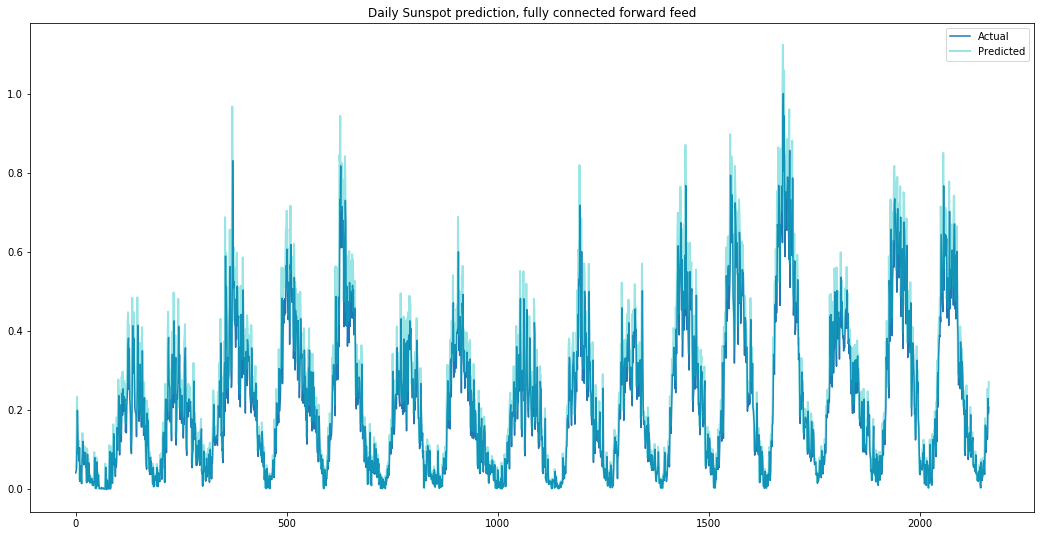

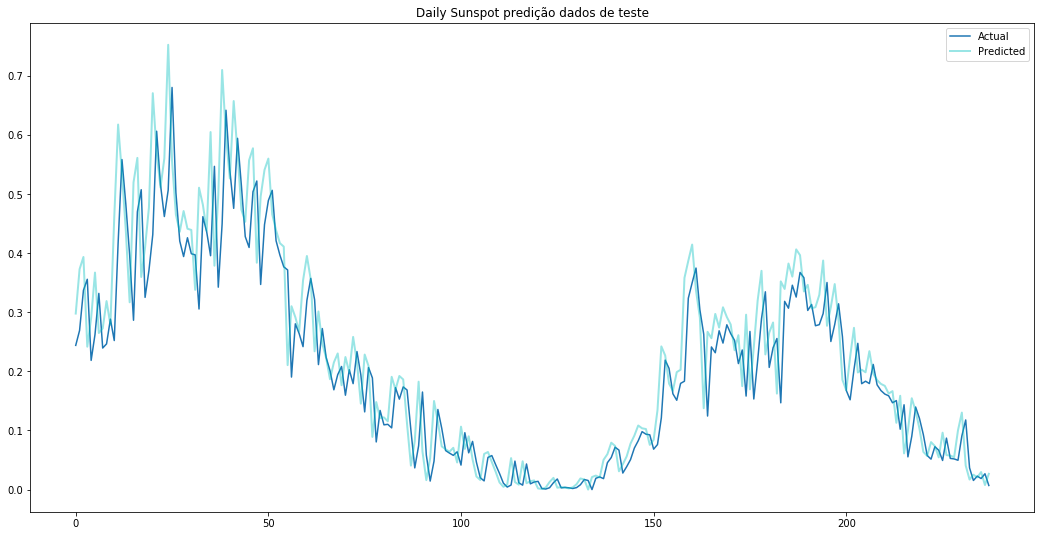

In [20]:
########################################################################
# test
#######################################################################


class FullyConnected:

    def __init__(self):
        
        # set up and initialize weights
        W_in_values = np.random.rand(n_hidden)
        self.W_in = theano.shared(value=W_in_values, name='W_in', borrow=True)

        W_h_values = np.random.rand(n_hidden, n_hidden)
        self.W_h = theano.shared(value=W_h_values, name='W_h', borrow=True)

        W_out_values = np.random.rand(n_hidden)
        self.W_out = theano.shared(value=W_out_values, name='W_out', borrow=True)


        self.parameters = [self.W_in, self.W_h, self.W_out]


        def save_weights():
            np.savez("Sunspot_weights.npz", *[p.get_value() for p in self.parameters])
        self.save_weights = save_weights
   

        # placeholders for data
        X = T.dscalar('X')
        Y = T.dscalar('Y')

        # -------------  feed forward ----------------------------

        # feed input to hidden units
        hidden_units = X * self.W_in 

        # take hidden output and send to other hidden nodes
        hidden_hidden = hidden_units * self.W_h      # node by column of weights

        # input from other hidden nodes
        hidden_out = T.nnet.relu(hidden_hidden.sum(axis=1) ) # sum row of weights

        # out from hidden nodes to output weights
        out = T.nnet.relu(hidden_out * self.W_out)   # hidden node outputs * output weights

        # predicted
        predicted = T.sum(out)                  # sum all incoming 

        # use to see which weight blow up and for regularization if used
        #sum_weights_in = T.sum(self.W_in)
        #sum_hidden_weights = T.sum(self.W_h)
        #sum_weights_out = T.sum(self.W_out)


        # error - regularization
        cost = (predicted - Y) **2 #- sum_hidden_weights * L1

        gradients = T.grad(cost, self.parameters)    # derivatives
        updates = [(p, p - learning_rate * g) for p, g in zip(self.parameters, gradients)]


        # training and prediction functions
        #self.weights_op = theano.function(inputs=[], outputs=[sum_weights_in, sum_hidden_weights, sum_weights_out])
        self.predict_op = theano.function(inputs = [X], outputs = predicted)

        self.train_op = theano.function(
                    inputs = [X, Y],
                    outputs = cost,
                    updates = updates
        )


    def train(self, x, y):

        costs = []
        for i in range(epochs):
            
            cost = 0
            predictions = []
            for j in range(len(y)):
                c = self.train_op(x[j], y[j])
                cost += c 
                #print(x[j], y[j], c)
                predictions.append( self.predict_op(x[j]))
                
                # check weights to see which ones are blowing up
                #print(self.weights_op())

            
            # output cost so user can see training progress
            cost /= len(y)
            print ("i:", i, "cost:", cost, "%")
            costs.append(cost)
            

        # graph to show accuracy progress - cost function should decrease
        plt.figure(figsize=(18,9))
        plt.plot(y, label='Actual')
        plt.plot(predictions, '-c',label='Predicted', linewidth=2, alpha=0.4)
        plt.legend(loc='best')
        plt.title("Daily Sunspot prediction, fully connected forward feed")
        #plt.savefig('daily_sunspots.png')
        plt.show()
        


        
        # predictions on unseen data
        new_predictions = []
        for k in range(len(x_valid)):
            p = self.predict_op(x_valid[k])
            new_predictions.append(p)


        # plot predicitons on unseen data
        plt.figure(figsize=(18,9))
        plt.plot(y_valid, label='Actual')
        plt.plot(new_predictions,'-c', label='Predicted', linewidth=2, alpha=0.4)
        #print(new_predictions[0:100])
        plt.legend(loc='best')
        plt.title("Daily Sunspot predição dados de teste")
# plt.savefig('daily_sunspots_validate_model.png')
        plt.show()
        

network = FullyConnected()
network.train(x, y)